
**PLANT CLASSIFICATION AND DIAGNOSE DETECTION WITH DEEP LEARNING**


In this project, the leaves of the plants will be identified and their diseases will be determined by using the deep learning-based selected method.

1- DATASET CLEANING AND PREPARATION

2- MODEL TRAINING TO DEFINE PLANTS' LEAVES

3- LEAF IDENTIFICATION MODEL TEST

4- DETERMINING THE TYPE OF A SINGLE LEAF GIVEN TO THE MODEL

5- EDUCATION OF DISEASE IDENTIFICATION MODELS

6- TEST OF DISEASE IDENTIFICATION MODELS

7- DETERMINING THE TYPE OF A SINGLE LEAF GIVEN TO THE MODEL



+ Inclusion of Another Deep Learning Method in the Program

Google Drive Import
=============================

In this secion we import and mount Google Drive to access the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/bitirme

/content/drive/MyDrive/bitirme


In [ ]:
%matplotlib inline

In [ ]:
#Unzip the downloaded file
#!unzip -q DB1.zip

Data Division
=============================

In this section we divide the dataset DB1 into train and test folders.

0.8 train size and 0.2 test size

In [ ]:
'''
# veriyi dagitma kodu
import os 
import random

from glob import glob 
from tqdm import tqdm 
for folder in tqdm(glob('DB1/*')):
  images = glob(folder + '/*')
  random.shuffle(images)

  train_size = int(len(images) * 0.8)
  
  train = images[:train_size]
  test = images[train_size:]
  
  os.makedirs(folder.replace('DB1/', 'DB1/train/'),exist_ok=True)
  os.makedirs(folder.replace('DB1/', 'DB1/test/'),exist_ok=True)

  [os.rename(i,i.replace('DB1/','DB1/train/')) for i in train]
  [os.rename(i,i.replace('DB1/','DB1/test/')) for i in test]
  
'''


First Section of the Project with AlexNet
===========================================

In this section we have complished the first section of the project.

We trained a deep learning model with Alexnet. After training we tested the model and get accuracy and loss rates.

Then we tested the model with single image and get the results. The results will show that which plant it belongs to and if it is healthy or unhealthy.




Import Necessary Libraries
--------------------------

In this section we import the necessary libraries

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Inputs
------

Here are all of the parameters to change for the run. 

We have prepared DB1 with images of PlantVillage dataset which is accessable from Kaggle. We will use the *DB1* dataset which can be downloaded
`here <https://drive.google.com/file/d/1asPQvaq5hwdxhtm8Fn_j47JDp3Bwm_Bu/view?usp=sharing`.


**This dataset contains 8 classes**

1.   Apple___healthy
2.   Apple___unhealthy
3.   Corn_(maize)___healthy
4.   Corn_(maize)___unhealthy
5.   Grape___healthy
6.   Grape___unhealthy
7.   Tomato___healthy
8.   Tomato___unhealthy

The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "./DB1"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Number of epochs to train for 
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Initialize and Reshape the Alexnet Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of Alexnet network. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since the AlexNet model have been pretrained on
Imagenet, it has all output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.


Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)
   

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}



Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import json
id2lab= {i:class_name for i,class_name in enumerate(dataloaders_dict['train'].dataset.classes)}
lab2id = {class_name : i for i , class_name  in id2lab.items()}

In [ ]:
id2lab

{0: 'Apple___healthy',
 1: 'Apple___unhealthy',
 2: 'Corn_(maize)___healthy',
 3: 'Corn_(maize)___unhealthy',
 4: 'Grape___healthy',
 5: 'Grape___unhealthy',
 6: 'Tomato___healthy',
 7: 'Tomato___unhealthy'}

In [ ]:
lab2id

{'Apple___healthy': 0,
 'Apple___unhealthy': 1,
 'Corn_(maize)___healthy': 2,
 'Corn_(maize)___unhealthy': 3,
 'Grape___healthy': 4,
 'Grape___unhealthy': 5,
 'Tomato___healthy': 6,
 'Tomato___unhealthy': 7}

In [ ]:
dataloaders_dict['train']

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
image_datasets

{'test': Dataset ImageFolder
     Number of datapoints: 1602
     Root location: ./DB1/test
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'train': Dataset ImageFolder
     Number of datapoints: 6396
     Root location: ./DB1/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


**TRAINING AND VALIDATION STEP**
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
from sklearn.model_selection import KFold
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):

    since = time.time()

    val_acc_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_history = [] 
    train_loss_history = [] 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_loss = epoch_loss.detach().cpu().numpy()
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # epoch_acc = epoch_acc.detach().cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history , val_loss_history, train_acc_history, train_loss_history

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
from sklearn.model_selection import KFold
n_fold = 5
kfold=KFold(n_splits=n_fold,shuffle=True)



initial_state = copy.deepcopy(model_ft.state_dict()) # Modelin ilk state


average_loss = 0 
best_loss = None
model_folder = '/content/drive/MyDrive/bitirme/DB1_MODELS'
saved_model = None

for fold,(train_idx,val_idx) in enumerate(kfold.split(image_datasets['train'])):
  print()
  print('Fold {}/{}'.format(fold+1, n_fold))
  print('=' * 20)
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

  trainloader = torch.utils.data.DataLoader(
                      image_datasets['train'], 
                      batch_size=batch_size, sampler=train_subsampler)
  valloader = torch.utils.data.DataLoader(
                      image_datasets['train'],
                      batch_size=batch_size, sampler=val_subsampler)
  model_ft.load_state_dict(initial_state)

  model_ft, val_acc_history , val_loss_history,train_acc_history,train_loss_history = train_model(model_ft,{'train' : trainloader , 'val' :valloader } , criterion, optimizer_ft, num_epochs=num_epochs)
  fold_loss = np.average(val_loss_history)
  average_loss += fold_loss
  if best_loss== None or fold_loss < best_loss:
    best_loss = fold_loss
    saved_model= copy.deepcopy(model_ft.state_dict())


print()
print('Average Loss = ', average_loss / n_fold )
print()
#torch.save(saved_model.state_dict(), 'saved_model' + model_name)



Fold 1/5
Epoch 1/20
----------
train Loss: 1.3585 Acc: 0.3168
val Loss: 0.1976 Acc: 0.1356

Epoch 2/20
----------
train Loss: 0.6202 Acc: 0.6043
val Loss: 0.1088 Acc: 0.1689

Epoch 3/20
----------
train Loss: 0.4303 Acc: 0.6651
val Loss: 0.0833 Acc: 0.1732

Epoch 4/20
----------
train Loss: 0.3432 Acc: 0.6914
val Loss: 0.0686 Acc: 0.1787

Epoch 5/20
----------
train Loss: 0.3010 Acc: 0.7047
val Loss: 0.0662 Acc: 0.1807

Epoch 6/20
----------
train Loss: 0.2808 Acc: 0.7097
val Loss: 0.0605 Acc: 0.1825

Epoch 7/20
----------
train Loss: 0.2689 Acc: 0.7153
val Loss: 0.0568 Acc: 0.1821

Epoch 8/20
----------
train Loss: 0.2557 Acc: 0.7211
val Loss: 0.0531 Acc: 0.1832

Epoch 9/20
----------
train Loss: 0.2556 Acc: 0.7190
val Loss: 0.0527 Acc: 0.1842

Epoch 10/20
----------
train Loss: 0.2371 Acc: 0.7267
val Loss: 0.0540 Acc: 0.1829

Epoch 11/20
----------
train Loss: 0.2353 Acc: 0.7231
val Loss: 0.0496 Acc: 0.1848

Epoch 12/20
----------
train Loss: 0.2250 Acc: 0.7251
val Loss: 0.0496 Acc:

## **SAVING THE MODEL**

In [ ]:
directory=model_name
path=os.path.join(model_folder, directory)
os.makedirs(path , exist_ok=True)
torch.save(saved_model, os.path.join(path , 'pytorch_model.bin'))
import pickle 
with open(os.path.join(path , 'labels.pkl') , 'wb') as fp :
  pickle.dump([id2lab,lab2id] , fp)


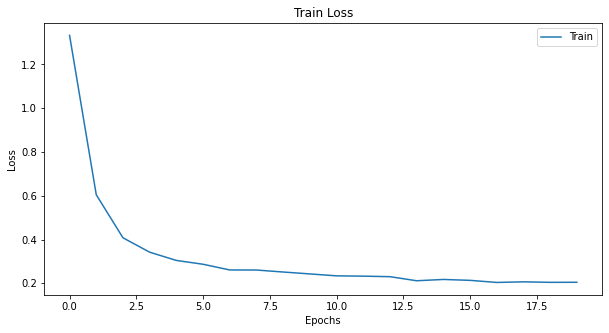

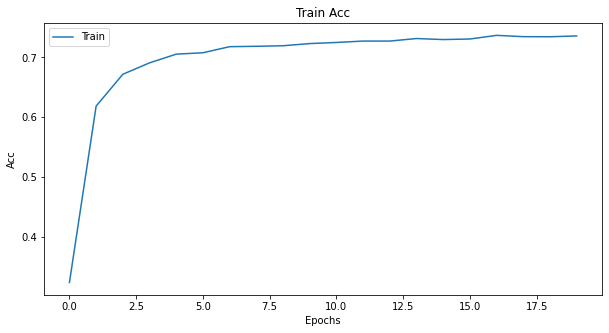

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Train Loss")
plt.plot(train_loss_history,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.title("Train Acc")
plt.plot(train_acc_history,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()



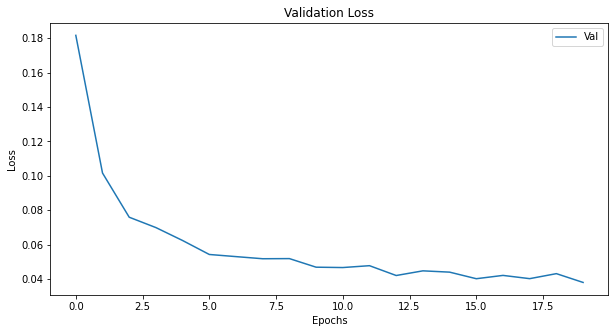

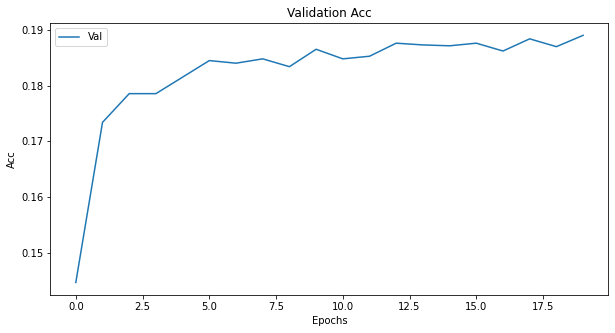

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(val_loss_history,label="Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.title("Validation Acc")
plt.plot(val_acc_history,label="Val")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

## **TESTING STEP**

In [ ]:
model_folder = '/content/drive/MyDrive/bitirme/DB1_MODELS/alexnet'

In [ ]:
model_ft.load_state_dict(torch.load(os.path.join(model_folder , 'pytorch_model.bin')))

<All keys matched successfully>

In [ ]:
with open(os.path.join(model_folder , 'labels.pkl') , 'rb') as fp :
  id2lab,lab2id = pickle.load(fp)

In [ ]:
model_ft.eval()

since = time.time()
val_acc_history = []
val_loss_history = []
best_acc = 0.0


running_loss = 0.0
running_corrects = 0

# Iterate over data.
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
running_corrects / len( dataloaders_dict['test'])

tensor(383., device='cuda:0')

In [ ]:
running_corrects

tensor(1532, device='cuda:0')

In [ ]:
running_loss

0.0

In [ ]:
len(os.listdir('/content/drive/MyDrive/bitirme/DB1/test/Apple___healthy'))

165

In [ ]:
len(os.listdir('/content/drive/MyDrive/bitirme/DB1/test/Corn_(maize)___healthy'))

233

In [ ]:
len(os.listdir('/content/drive/MyDrive/bitirme/DB1/test/Grape___healthy'))

85

In [ ]:
len(os.listdir('/content/drive/MyDrive/bitirme/DB1/test/Tomato___healthy'))

318

In [ ]:
len(dataloaders_dict['test'])

4

PREDICTION THE TYPE OF INPUT PHOTO
===========================================





In [ ]:
#Test One Image
model_ft.eval()
from PIL import Image
def test_one_image(model_ft,data_transforms, image_path) :
  im = Image.open(image_path)
  im = data_transforms['test'](im)
  im = torch.unsqueeze(im, 0).to(device)
  with torch.set_grad_enabled(False):
      outputs = model_ft(im)
      _, preds = torch.max(outputs, 1)
      return preds.detach().cpu().numpy()

In [ ]:
id2lab

{0: 'Apple___healthy',
 1: 'Apple___unhealthy',
 2: 'Corn_(maize)___healthy',
 3: 'Corn_(maize)___unhealthy',
 4: 'Grape___healthy',
 5: 'Grape___unhealthy',
 6: 'Tomato___healthy',
 7: 'Tomato___unhealthy'}

In [ ]:
preds = test_one_image(model_ft, data_transforms , 'DB1/test/Tomato___unhealthy/009dd1f5-281a-4e54-9f80-a068d0d8cfcd___YLCV_NREC 2162.JPG')

In [ ]:
print(preds)

[7]
